# LESSON 4: TEXT GENERATION METRICS 🌍
*Grading AI writers - BLEU & ROUGE explained*

## What You'll Learn
- **BLEU** - For translation (is your translator lying?)
- **ROUGE** - For summarization (did you skip the important parts?)
- **N-grams** - Why order matters ("dog bites man" ≠ "man bites dog")
- **When to use what** - Translation vs Summarization

## Real Talk
When AI generates text, how do we know if it's good? You can't just count "correct" like classification.

**The problem:** There are infinite correct ways to say the same thing!
- "The cat sat" vs "A cat was sitting" vs "There was a cat, and it sat"

All correct! So how do we grade this? Enter BLEU and ROUGE - the metrics that compare your AI's output to human references.

**Spoiler:** They're not perfect (they don't understand meaning), but they're what we got! 🤷

Let's dive in! 🚀

In [8]:
# Install required packages (run this first!)
import subprocess
import sys

packages = ['nltk', 'rouge-score', 'numpy', 'matplotlib']
print("Checking/installing packages...")
for package in packages:
    try:
        __import__(package.replace('-', '_'))
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
print("✓ All packages ready!\n")

# Setup
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
import nltk
nltk.download('punkt', quiet=True)

print("🌍 Text Generation Evaluation Notebook Loaded!")
print("We'll learn BLEU (translation) and ROUGE (summarization)!")

Checking/installing packages...
✓ All packages ready!

🌍 Text Generation Evaluation Notebook Loaded!
We'll learn BLEU (translation) and ROUGE (summarization)!


## 📊 Step 1: BLEU Score 🌍
*For translation - counts matching word chunks (n-grams)*

### What is it?
**BLEU** = Bilingual Evaluation Understudy (fancy name for "do the words match?")

It counts how many **n-grams** (word sequences) match between:
- Your AI's translation
- A human reference translation

**What's an "n-gram"?** A sequence of n consecutive words:
- 1-gram (unigram): single word ["cat"]
- 2-gram (bigram): two words ["the cat"]  
- 3-gram (trigram): three words ["the cat sat"]

### The Metaphor
Imagine translating English → Spanish. BLEU is like a teacher who:
1. Checks if you used the right words ✓
2. Checks if you put them in the right order ✓
3. Doesn't care if you understood the meaning ✗

**Example:**
- Reference: "The cat sat on the mat"
- Your AI: "Cat mat on sat the" ← All the right words, WRONG order!
- BLEU: "Yo this is trash" (low score)

### Why BLEU has limitations (but is still widely used)
- Uses "quick" and "fast"? BLEU thinks they're different words 🤦
- Synonyms? BLEU doesn't know what those are
- Different sentence structure but same meaning? Penalized!

But hey, it's fast and works well enough for most cases!

Let's see it in action...

In [9]:
print("🌍 BLEU SCORE - For Translation Quality")
print("="*60)
print("BLEU = Bi-Lingual Evaluation Understudy")
print("Measures how similar generated text is to reference")
print()

# Reference (correct translation)
reference = "The cat sat on the mat".lower().split()

# Different quality translations
translations = [
    ("The cat sat on the mat", "Perfect match"),
    ("The cat is on the mat", "Good (minor difference)"),
    ("A cat sat on a mat", "Okay (different articles)"),
    ("Cat mat on sat the", "Bad (wrong order)"),
    ("The dog stood near the chair", "Terrible (different meaning)")
]

print(f"Reference translation: '{' '.join(reference)}'\n")

for trans_text, description in translations:
    candidate = trans_text.lower().split()
    
    # Calculate BLEU
    bleu = sentence_bleu([reference], candidate)
    
    # Rating
    if bleu > 0.8:
        rating = "🔥"
    elif bleu > 0.5:
        rating = "👍"
    elif bleu > 0.3:
        rating = "😐"
    else:
        rating = "💩"
    
    print(f"{description:30s} → BLEU: {bleu:.3f} {rating}")
    print(f"  Generated: '{trans_text}'")
    
    # Show matching words
    matches = set(reference) & set(candidate)
    print(f"  Matching words: {matches}\n")

print("💡 BLEU Score range: 0.0 to 1.0 (higher = better)")
print("   0.5+ = Good translation")
print("   0.3-0.5 = Decent")
print("   <0.3 = Needs work")

🌍 BLEU SCORE - For Translation Quality
BLEU = Bi-Lingual Evaluation Understudy
Measures how similar generated text is to reference

Reference translation: 'the cat sat on the mat'

Perfect match                  → BLEU: 1.000 🔥
  Generated: 'The cat sat on the mat'
  Matching words: {'sat', 'on', 'mat', 'cat', 'the'}

Good (minor difference)        → BLEU: 0.000 💩
  Generated: 'The cat is on the mat'
  Matching words: {'on', 'mat', 'the', 'cat'}

Okay (different articles)      → BLEU: 0.000 💩
  Generated: 'A cat sat on a mat'
  Matching words: {'sat', 'on', 'mat', 'cat'}

Bad (wrong order)              → BLEU: 0.000 💩
  Generated: 'Cat mat on sat the'
  Matching words: {'sat', 'on', 'mat', 'cat', 'the'}

Terrible (different meaning)   → BLEU: 0.000 💩
  Generated: 'The dog stood near the chair'
  Matching words: {'the'}

💡 BLEU Score range: 0.0 to 1.0 (higher = better)
   0.5+ = Good translation
   0.3-0.5 = Decent
   <0.3 = Needs work


## 📊 Step 2: N-grams Deep Dive
*Why "dog bites man" ≠ "man bites dog"*

### What are n-grams?
- **1-gram (unigram):** Individual words ["the", "cat", "sat"]
- **2-gram (bigram):** Word pairs ["the cat", "cat sat"]
- **3-gram (trigram):** Word triples ["the cat sat"]
- **4-gram:** You get the idea...

### Why n-grams matter
Just matching individual words isn't enough!

**Example:**
- Reference: "The dog bit the man"
- Translation 1: "The man bit the dog" ← Same words, OPPOSITE meaning!
- Translation 2: "The dog bit the man" ← Perfect!

**1-gram matching alone:** Both get 100%! (all words match)  
**2-gram matching:** Translation 1 fails! ("dog bit" vs "man bit")

This is why BLEU checks multiple n-gram sizes!

Let's see the math...

In [10]:
from nltk.translate.bleu_score import sentence_bleu
from collections import Counter

reference = "the quick brown fox jumps over the lazy dog".split()
candidate = "the fast brown fox leaps over the lazy dog".split()

print("="*60)
print("BLEU BREAKDOWN")
print("="*60)
print(f"Reference:  {' '.join(reference)}")
print(f"Generated:  {' '.join(candidate)}")

# Count n-gram matches
def count_ngram_matches(ref, cand, n):
    ref_ngrams = [tuple(ref[i:i+n]) for i in range(len(ref)-n+1)]
    cand_ngrams = [tuple(cand[i:i+n]) for i in range(len(cand)-n+1)]
    
    ref_counts = Counter(ref_ngrams)
    cand_counts = Counter(cand_ngrams)
    
    matches = sum((ref_counts & cand_counts).values())
    total = len(cand_ngrams)
    
    return matches, total, matches/total if total > 0 else 0

print("\nn-gram precision:")
for n in range(1, 5):
    matches, total, precision = count_ngram_matches(reference, candidate, n)
    print(f"  {n}-gram: {matches}/{total} = {precision:.1%}")

# Overall BLEU
bleu = sentence_bleu([reference], candidate)
print(f"\nOverall BLEU: {bleu:.3f}")

print("\nWhat changed:")
print("  'quick' → 'fast' (synonym, but BLEU doesn't know that!)")
print("  'jumps' → 'leaps' (synonym, but BLEU penalizes it)")
print("\n💡 BLEU limitation: Doesn't understand synonyms or meaning!")

BLEU BREAKDOWN
Reference:  the quick brown fox jumps over the lazy dog
Generated:  the fast brown fox leaps over the lazy dog

n-gram precision:
  1-gram: 7/9 = 77.8%
  2-gram: 4/8 = 50.0%
  3-gram: 2/7 = 28.6%
  4-gram: 1/6 = 16.7%

Overall BLEU: 0.369

What changed:
  'quick' → 'fast' (synonym, but BLEU doesn't know that!)
  'jumps' → 'leaps' (synonym, but BLEU penalizes it)

💡 BLEU limitation: Doesn't understand synonyms or meaning!


### 🎯 CHALLENGE: Test Your Own Translations!

Want to see how BLEU scores different translations?

**Try this:**
1. Pick a simple sentence in another language you know
2. Create 3-5 different English translations (exact, with synonyms, reordered, etc.)
3. Use `sentence_bleu()` to score each one
4. See how BLEU handles synonyms vs word order

**Question:** Which matters more to BLEU - using exact words or getting the order right?

**Hint:** Try "The dog chases the cat" vs "The cat chases the dog" vs "A dog pursues a cat"

## 📊 Step 3: ROUGE Score 📝
*For summarization - did you include the important parts?*

### What is it?
**ROUGE** = Recall-Oriented Understudy for Gisting Evaluation (yeah, they really tried with that acronym)

Unlike BLEU (precision), ROUGE focuses on **RECALL** - did you cover the key content?

### The Difference
- **BLEU asks:** "Is everything you said correct?" (precision)
- **ROUGE asks:** "Did you include all the important stuff?" (recall)

**What's Precision vs Recall again?**
- **Precision**: Of what you said, how much was correct? (quality of output)
- **Recall**: Of what should be said, how much did you include? (completeness)

### The Metaphor
You're summarizing a movie for a friend:

**BLEU mindset:** "Everything I said was accurate!" (but you only mentioned one scene)  
**ROUGE mindset:** "Did I cover all the major plot points?" (completeness matters!)

### ROUGE Flavors
- **ROUGE-1:** Word overlap (unigrams)
- **ROUGE-2:** Phrase overlap (bigrams)  
- **ROUGE-L:** Longest common **subsequence** (order-aware matching)

**What's a "subsequence"?** Words that appear in the same order, but not necessarily consecutively. Example: In "the quick brown fox", "the brown fox" is a subsequence (skips "quick").

Let's see it work!

In [11]:
print("="*60)
print("ROUGE SCORE EXAMPLES")
print("="*60)

# Reference summary
reference_summary = """Machine learning models require evaluation metrics 
to measure their performance on test data."""

# Different quality summaries
summaries = [
    (
        "Machine learning models require evaluation metrics to measure performance.",
        "Good (covers main points)"
    ),
    (
        "Models need metrics to evaluate performance on data.",
        "Okay (shorter but captures essence)"
    ),
    (
        "Deep learning is a subset of machine learning.",
        "Bad (different topic)"
    )
]

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

print(f"\nReference summary:")
print(f"  '{reference_summary.strip()}'\n")

for summary, description in summaries:
    scores = scorer.score(reference_summary, summary)
    
    print(f"{description}")
    print(f"  Generated: '{summary}'")
    print(f"  ROUGE-1: {scores['rouge1'].fmeasure:.3f} (unigram overlap)")
    print(f"  ROUGE-2: {scores['rouge2'].fmeasure:.3f} (bigram overlap)")
    print(f"  ROUGE-L: {scores['rougeL'].fmeasure:.3f} (longest common subsequence)")
    print()

ROUGE SCORE EXAMPLES

Reference summary:
  'Machine learning models require evaluation metrics 
to measure their performance on test data.'

Good (covers main points)
  Generated: 'Machine learning models require evaluation metrics to measure performance.'
  ROUGE-1: 0.818 (unigram overlap)
  ROUGE-2: 0.700 (bigram overlap)
  ROUGE-L: 0.818 (longest common subsequence)

Okay (shorter but captures essence)
  Generated: 'Models need metrics to evaluate performance on data.'
  ROUGE-1: 0.667 (unigram overlap)
  ROUGE-2: 0.211 (bigram overlap)
  ROUGE-L: 0.571 (longest common subsequence)

Bad (different topic)
  Generated: 'Deep learning is a subset of machine learning.'
  ROUGE-1: 0.190 (unigram overlap)
  ROUGE-2: 0.105 (bigram overlap)
  ROUGE-L: 0.190 (longest common subsequence)



## 📊 Step 4: ROUGE Components Explained
*Breaking down the ROUGE scores*

In [12]:
reference = "the cat sat on the mat"
candidate = "the cat is on the mat"

scores = scorer.score(reference, candidate)

print("="*60)
print("ROUGE BREAKDOWN")
print("="*60)
print(f"Reference: '{reference}'")
print(f"Generated: '{candidate}'")

print("\nROUGE-1 (unigram):")
ref_words = set(reference.split())
cand_words = set(candidate.split())
overlap = ref_words & cand_words
print(f"  Overlapping words: {overlap}")
print(f"  Precision: {len(overlap)}/len(cand) = {scores['rouge1'].precision:.3f}")
print(f"  Recall:    {len(overlap)}/len(ref) = {scores['rouge1'].recall:.3f}")
print(f"  F1:        {scores['rouge1'].fmeasure:.3f}")

print("\nROUGE-2 (bigram):")
ref_bigrams = [f"{reference.split()[i]} {reference.split()[i+1]}" 
               for i in range(len(reference.split())-1)]
cand_bigrams = [f"{candidate.split()[i]} {candidate.split()[i+1]}" 
                for i in range(len(candidate.split())-1)]
print(f"  Reference bigrams: {ref_bigrams}")
print(f"  Generated bigrams: {cand_bigrams}")
print(f"  ROUGE-2 F1: {scores['rouge2'].fmeasure:.3f}")

print("\n💡 ROUGE focuses on RECALL (did you include the key info?)")
print("   BLEU focuses on PRECISION (is what you said accurate?)")

ROUGE BREAKDOWN
Reference: 'the cat sat on the mat'
Generated: 'the cat is on the mat'

ROUGE-1 (unigram):
  Overlapping words: {'on', 'mat', 'the', 'cat'}
  Precision: 4/len(cand) = 0.833
  Recall:    4/len(ref) = 0.833
  F1:        0.833

ROUGE-2 (bigram):
  Reference bigrams: ['the cat', 'cat sat', 'sat on', 'on the', 'the mat']
  Generated bigrams: ['the cat', 'cat is', 'is on', 'on the', 'the mat']
  ROUGE-2 F1: 0.600

💡 ROUGE focuses on RECALL (did you include the key info?)
   BLEU focuses on PRECISION (is what you said accurate?)


## 📊 Step 5: BLEU vs ROUGE Showdown 🥊
*When to use what (and why they both have limitations)*

Let's test both on the same examples and see how they differ!

### The Setup
- **Reference:** "The quick brown fox jumps over the lazy dog"
- **Test cases:** Perfect match, synonyms, missing words, incomplete

### What We'll Learn
- BLEU is harsh on synonyms (doesn't understand meaning)
- ROUGE is more forgiving (cares about coverage)
- Both miss semantic meaning (they're word-counters, not mind-readers)

Let's visualize the difference...

BLEU vs ROUGE - WHEN TO USE WHAT


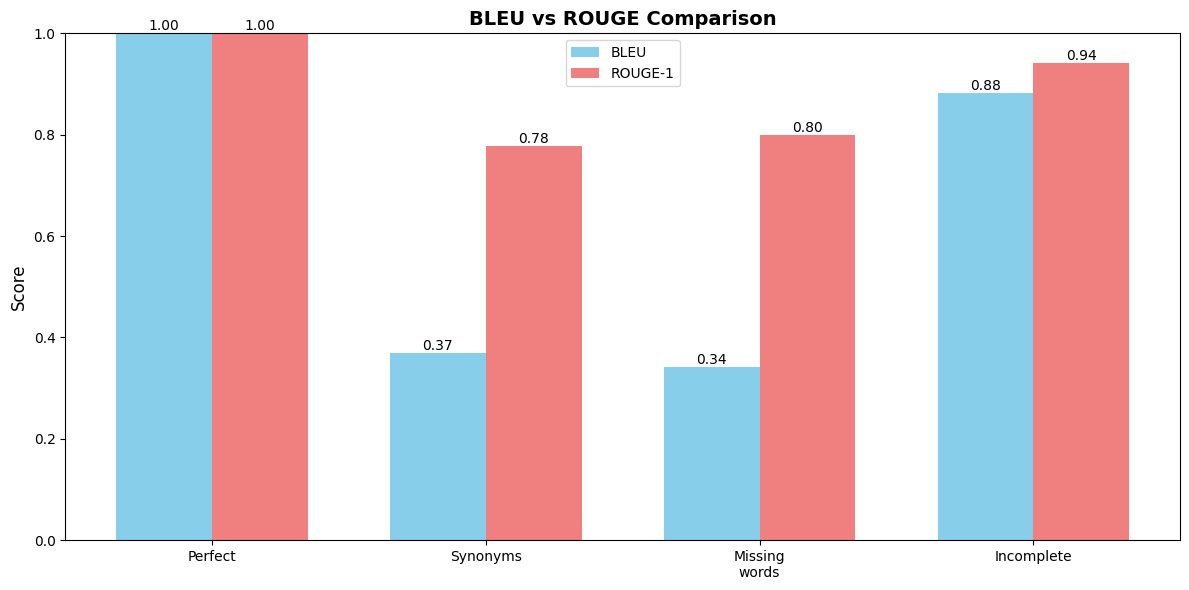


🧠 ANALYZING THE BAR CHART:

📊 COMPARING THE BARS ACROSS 4 TEST CASES:

1. PERFECT:
   Test: 'The quick brown fox jumps over the lazy dog'
   🔵 BLEU  (blue):  1.000
   🔴 ROUGE (red):   1.000
   ✨ Both 1.0! Perfect match = perfect scores

2. SYNONYMS:
   Test: 'The fast brown fox leaps over the lazy dog'
   🔵 BLEU  (blue):  0.369
   🔴 ROUGE (red):   0.778
   ⚡ BIG DIFFERENCE! BLEU harsh on synonyms, ROUGE more forgiving
      → BLEU: 'fast' ≠ 'quick'? PENALIZED! (precision-focused)
      → ROUGE: 'fast' similar to 'quick'? More tolerant! (recall-focused)

3. MISSING WORDS:
   Test: 'The fox jumps over the dog'
   🔵 BLEU  (blue):  0.341
   🔴 ROUGE (red):   0.800
   📉 ROUGE higher! Missing words hurt BLEU more (needs exact matches)
      → BLEU cares about ALL words matching exactly
      → ROUGE cares about covering KEY words (more forgiving)

4. INCOMPLETE:
   Test: 'The quick brown fox jumps over the lazy'
   🔵 BLEU  (blue):  0.882
   🔴 ROUGE (red):   0.941
   ⚠️ Both drop but BLEU dro

In [13]:
import matplotlib.pyplot as plt

print("="*60)
print("BLEU vs ROUGE - WHEN TO USE WHAT")
print("="*60)

# Test on same example
reference_text = "The quick brown fox jumps over the lazy dog"
ref_tokens = reference_text.lower().split()

test_cases = [
    "The quick brown fox jumps over the lazy dog",  # Perfect
    "The fast brown fox leaps over the lazy dog",   # Synonyms
    "The fox jumps over the dog",                   # Missing words
    "The quick brown fox jumps over the lazy",      # Incomplete
]

bleu_scores = []
rouge_scores = []

for test in test_cases:
    # BLEU
    bleu = sentence_bleu([ref_tokens], test.lower().split())
    bleu_scores.append(bleu)
    
    # ROUGE
    rouge = scorer.score(reference_text, test)['rouge1'].fmeasure
    rouge_scores.append(rouge)

# Plot comparison
x = np.arange(len(test_cases))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, bleu_scores, width, label='BLEU', color='skyblue')
bars2 = ax.bar(x + width/2, rouge_scores, width, label='ROUGE-1', color='lightcoral')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('BLEU vs ROUGE Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Perfect', 'Synonyms', 'Missing\nwords', 'Incomplete'], fontsize=10)
ax.legend()
ax.set_ylim(0, 1.0)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n🧠 ANALYZING THE BAR CHART:")
print("="*60)

print("\n📊 COMPARING THE BARS ACROSS 4 TEST CASES:")

for i, (test_case, bleu, rouge) in enumerate(zip(['Perfect', 'Synonyms', 'Missing words', 'Incomplete'], bleu_scores, rouge_scores)):
    print(f"\n{i+1}. {test_case.upper()}:")
    print(f"   Test: '{test_cases[i]}'")
    print(f"   🔵 BLEU  (blue):  {bleu:.3f}")
    print(f"   🔴 ROUGE (red):   {rouge:.3f}")
    
    # Analyze the difference
    diff = abs(bleu - rouge)
    if test_case == 'Perfect':
        print(f"   ✨ Both 1.0! Perfect match = perfect scores")
    elif test_case == 'Synonyms':
        if bleu < 0.5 and rouge > 0.7:
            print(f"   ⚡ BIG DIFFERENCE! BLEU harsh on synonyms, ROUGE more forgiving")
            print(f"      → BLEU: 'fast' ≠ 'quick'? PENALIZED! (precision-focused)")
            print(f"      → ROUGE: 'fast' similar to 'quick'? More tolerant! (recall-focused)")
    elif test_case == 'Missing words':
        if bleu < rouge:
            print(f"   📉 ROUGE higher! Missing words hurt BLEU more (needs exact matches)")
            print(f"      → BLEU cares about ALL words matching exactly")
            print(f"      → ROUGE cares about covering KEY words (more forgiving)")
    elif test_case == 'Incomplete':
        print(f"   ⚠️ Both drop but BLEU drops MORE (strict about completeness)")

print("\n💡 THE BIG PICTURE:")
print("="*60)

# Overall comparison
avg_bleu = np.mean(bleu_scores[1:])  # Skip perfect match
avg_rouge = np.mean(rouge_scores[1:])

print(f"\n📈 Average scores (excluding perfect match):")
print(f"   BLEU:  {avg_bleu:.3f} (more strict)")
print(f"   ROUGE: {avg_rouge:.3f} (more forgiving)")

if avg_rouge > avg_bleu * 1.3:
    print(f"\n🔥 ROUGE is way more forgiving than BLEU!")
    print(f"   → BLEU: 'Did you use EXACT words?' (precision nerd)")
    print(f"   → ROUGE: 'Did you cover IMPORTANT stuff?' (chill about synonyms)")
elif avg_bleu > avg_rouge:
    print(f"\n⚡ BLEU stricter than ROUGE in this case!")
else:
    print(f"\n👍 Both metrics roughly agree")

print("\n🎯 WHEN TO USE WHAT:")
print("  📘 BLEU (skyblue bars):")
print("     ✓ Precision-focused - penalizes wrong/extra words")
print("     ✓ Strict about exact matches")
print("     ✓ Use for: Translation (accuracy matters!)")
print("     ✗ Harsh on synonyms (doesn't understand meaning)")

print("\n  📕 ROUGE (coral bars):")
print("     ✓ Recall-focused - rewards covering key content")
print("     ✓ More forgiving on wording")
print("     ✓ Use for: Summarization (completeness matters!)")
print("     ⚡ Can miss if you add wrong stuff (less strict)")

print("\n💀 BOTH HAVE LIMITATIONS:")
print("   → They count words, they don't understand MEANING")
print("   → 'quick' vs 'fast'? They think those are different words")
print("   → But hey, they're fast and work well enough for most cases!")

## 📊 Step 6: Real-World Summarization Example
*See ROUGE grade different summary qualities*

Here's a real article and summaries at different quality levels.

### The Harsh Truth
- **Good summary (ROUGE ~0.6):** Covers main points, good word overlap
- **Too short (ROUGE ~0.1):** Misses key info, weak overlap
- **Wrong focus (ROUGE ~0.2):** Talks about related stuff but misses the point

ROUGE will roast bad summaries! Let's see...

In [14]:
print("📝 REAL SUMMARIZATION EXAMPLE")
print("="*60)

# Long article
article = """Machine learning evaluation metrics are essential for understanding 
model performance. For classification tasks, we use accuracy, precision, recall, 
and F1-score. For regression, we use MAE, MSE, RMSE, and R-squared. Text generation 
tasks require special metrics like BLEU for translation and ROUGE for summarization. 
Each metric serves a specific purpose and choosing the right one depends on your task."""

# Reference summary
reference_summary = """ML metrics include classification metrics like accuracy and F1, 
regression metrics like RMSE, and text generation metrics like BLEU and ROUGE."""

# Generated summaries (different quality)
generated_summaries = [
    ("Good", """Machine learning uses different metrics: classification uses accuracy 
    and F1, regression uses RMSE, and text generation uses BLEU and ROUGE."""),
    
    ("Too short", "ML has many evaluation metrics for different tasks."),
    
    ("Wrong focus", """Classification and regression are important types of 
    machine learning that require careful evaluation."""),
]

print(f"\n📄 Original article ({len(article.split())} words):")
print(article)
print(f"\n✅ Reference summary ({len(reference_summary.split())} words):")
print(reference_summary)

print("\n" + "="*60)
print("EVALUATING GENERATED SUMMARIES")
print("="*60)

for quality, summary in generated_summaries:
    scores = scorer.score(reference_summary, summary)
    
    print(f"\n{quality.upper()} summary ({len(summary.split())} words):")
    print(f"  {summary.strip()}")
    print(f"\n  📊 Scores:")
    print(f"    ROUGE-1: {scores['rouge1'].fmeasure:.3f} (word overlap)")
    print(f"    ROUGE-2: {scores['rouge2'].fmeasure:.3f} (phrase overlap)")
    print(f"    ROUGE-L: {scores['rougeL'].fmeasure:.3f} (longest match)")

print("\n" + "="*60)
print("🧠 LESSON COMPLETE - KEY TAKEAWAYS:")
print("="*60)
print("\n1. BLEU SCORE (Translation)")
print("   ✓ Precision-focused (is generated text accurate?)")
print("   ✓ Counts n-gram matches")
print("   ✗ Doesn't understand synonyms or meaning")
print("   ✓ Use for: Machine translation")
print()
print("2. ROUGE SCORE (Summarization)")
print("   ✓ Recall-focused (does it cover key content?)")
print("   ✓ ROUGE-1: Word overlap")
print("   ✓ ROUGE-2: Phrase overlap")
print("   ✓ ROUGE-L: Longest common sequence")
print("   ✓ Use for: Summarization, captions")
print()
print("3. WHEN TO USE WHAT")
print("   Translation → BLEU (accuracy matters)")
print("   Summarization → ROUGE (completeness matters)")
print()
print("🎉 Great job learning text generation metrics!")
print("\n🚀 Next up: Lesson 5 - ROC/AUC (Advanced Classification)!")

📝 REAL SUMMARIZATION EXAMPLE

📄 Original article (58 words):
Machine learning evaluation metrics are essential for understanding 
model performance. For classification tasks, we use accuracy, precision, recall, 
and F1-score. For regression, we use MAE, MSE, RMSE, and R-squared. Text generation 
tasks require special metrics like BLEU for translation and ROUGE for summarization. 
Each metric serves a specific purpose and choosing the right one depends on your task.

✅ Reference summary (21 words):
ML metrics include classification metrics like accuracy and F1, 
regression metrics like RMSE, and text generation metrics like BLEU and ROUGE.

EVALUATING GENERATED SUMMARIES

GOOD summary (20 words):
  Machine learning uses different metrics: classification uses accuracy 
    and F1, regression uses RMSE, and text generation uses BLEU and ROUGE.

  📊 Scores:
    ROUGE-1: 0.634 (word overlap)
    ROUGE-2: 0.410 (phrase overlap)
    ROUGE-L: 0.634 (longest match)

TOO SHORT summary (8 words):